In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model
import ta  # Technical Analysis library
import matplotlib.pyplot as plt

In [2]:
# Load the saved direction prediction model
with open('Direction_LSTM.pkl', 'rb') as file:
    direction_model = pickle.load(file)

# Load the saved magnitude prediction model
with open('Magnitude_LSTM.pkl', 'rb') as file:
    magnitude_model = pickle.load(file)

# Load the unseen validation data
validation_data = pd.read_csv('cValidation_data')

In [3]:

# Feature Engineering on validation data
# Calculate Technical Indicators
validation_data['SMA'] = validation_data['Close'].rolling(window=14).mean()
validation_data['EMA'] = validation_data['Close'].ewm(span=14, adjust=False).mean()
validation_data['RSI'] = ta.momentum.RSIIndicator(validation_data['Close'], window=14).rsi()
validation_data['MACD'] = ta.trend.MACD(validation_data['Close']).macd()
validation_data['Bollinger_Upper'] = ta.volatility.BollingerBands(validation_data['Close']).bollinger_hband()
validation_data['Bollinger_Lower'] = ta.volatility.BollingerBands(validation_data['Close']).bollinger_lband()

# Create Lagged Features
for lag in range(1, 4):
    validation_data[f'Lag_{lag}'] = validation_data['Close'].shift(lag)

# Drop rows with NaN values
validation_data.dropna(inplace=True)

# Prepare features for direction prediction
direction_features = validation_data[['Open', 'High', 'Low', 'Close', 'Volume', 'SMA', 'EMA', 'RSI', 'MACD', 
                                      'Bollinger_Upper', 'Bollinger_Lower', 'Lag_1', 'Lag_2', 'Lag_3']]

# Scale the features for direction prediction
scaler_direction = MinMaxScaler(feature_range=(0, 1))
scaled_direction_features = scaler_direction.fit_transform(direction_features)

# Reshape for LSTM direction prediction
scaled_direction_features_lstm = scaled_direction_features.reshape((scaled_direction_features.shape[0], 1, scaled_direction_features.shape[1]))

In [4]:
# Predict the direction using the direction model
predicted_direction = (direction_model.predict(scaled_direction_features_lstm) > 0.5).astype(int)
print(predicted_direction)

5/5 [==============================] - 0s 852us/step
[[0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]]


In [5]:
predicted_direction = (direction_model.predict(scaled_direction_features_lstm) > 0.5).astype(int)

# Add the predicted direction as a feature to the validation data
validation_data['Predicted_Direction'] = predicted_direction

# Prepare features for magnitude (price) prediction, including the predicted direction
magnitude_features = validation_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Predicted_Direction']]
target = validation_data['Close']

# Scale the data for magnitude prediction
scaler_magnitude = MinMaxScaler(feature_range=(0, 1))
scaled_magnitude_data = scaler_magnitude.fit_transform(magnitude_features)

# Create sequences of data for the LSTM magnitude model
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 3])  # Use the 'Close' price as the target
    return np.array(X), np.array(y)

seq_length = 60  # Using 60 days of data to predict the next day's price
X_val, y_val = create_sequences(scaled_magnitude_data, seq_length)

5/5 [==============================] - 0s 757us/step


In [6]:
# Predict the magnitude using the magnitude model
predicted_prices = magnitude_model.predict(X_val)

3/3 [==============================] - 1s 7ms/step


In [7]:
# Inverse transform the predicted and actual values to get them in the original scale
predicted_prices = scaler_magnitude.inverse_transform(np.concatenate([X_val[:, -1, :-1], predicted_prices], axis=1))[:, -1]
actual_prices = scaler_magnitude.inverse_transform(np.concatenate([X_val[:, -1, :-1], y_val.reshape(-1, 1)], axis=1))[:, -1]
print(actual_prices)
print(predicted_prices)

[0.18366185 0.20266047 0.09696704 0.21526042 0.24000913 0.29389024
 0.3140681  0.2774757  0.26977474 0.35202689 0.32030271 0.37005391
 0.41523684 0.57706733 0.529731   0.54625065 0.51475463 0.50258536
 0.4381449  0.41121459 0.48637847 0.51703877 0.49549196 0.38785534
 0.46009162 0.49802477 0.6148723  0.55999395 0.54421774 0.58701654
 0.33852969 0.30709007 0.25562383 0.41221951 0.25240142 0.17355882
 0.25636983 0.25984347 0.2797137  0.18267744 0.14256783 0.23926569
 0.18958114 0.12611996 0.18711498 0.24471584 0.24868168 0.27300484
 0.36955145 0.4399112  0.45050131 0.4157393  0.45554641 0.54040315
 0.56789231 0.60234413 0.60438729 0.68544225 0.60234413 0.59723237
 0.57706733 0.49295915 0.46893081 0.49422556 0.49954497 0.42580387
 0.41850539 0.43537368 0.35728221 0.62229383 0.70862718 0.65536645
 0.65947329 0.63279678 0.62869507 0.67694915 0.80755792 0.84245836
 0.75539952 0.86778643 1.        ]
[0.19319557 0.18672398 0.17001602 0.0978668  0.12891549 0.2491177
 0.30952615 0.30623323 0.265

In [8]:
from sklearn.metrics import r2_score
import statsmodels.api as sm


# Evaluate the model
mse = np.mean((predicted_prices - actual_prices) ** 2)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r_squared = r2_score(actual_prices, predicted_prices)
print(f"R-squared: {r_squared}")

# Adding a constant to the predicted prices to represent the intercept
X = sm.add_constant(predicted_prices)

# Fit the model (y = actual_prices)
ols_model = sm.OLS(actual_prices, X).fit()

# Get the p-values
p_values = ols_model.pvalues
print(f"P-value of the model: {p_values[1]}")

# Alternatively, print the summary of the model to see all details
print(ols_model.summary())

Mean Squared Error: 0.004468392774852327
R-squared: 0.8721888864077951
P-value of the model: 4.9244237423462833e-39
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     615.3
Date:                Wed, 28 Aug 2024   Prob (F-statistic):           4.92e-39
Time:                        00:22:27   Log-Likelihood:                 108.91
No. Observations:                  81   AIC:                            -213.8
Df Residuals:                      79   BIC:                            -209.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

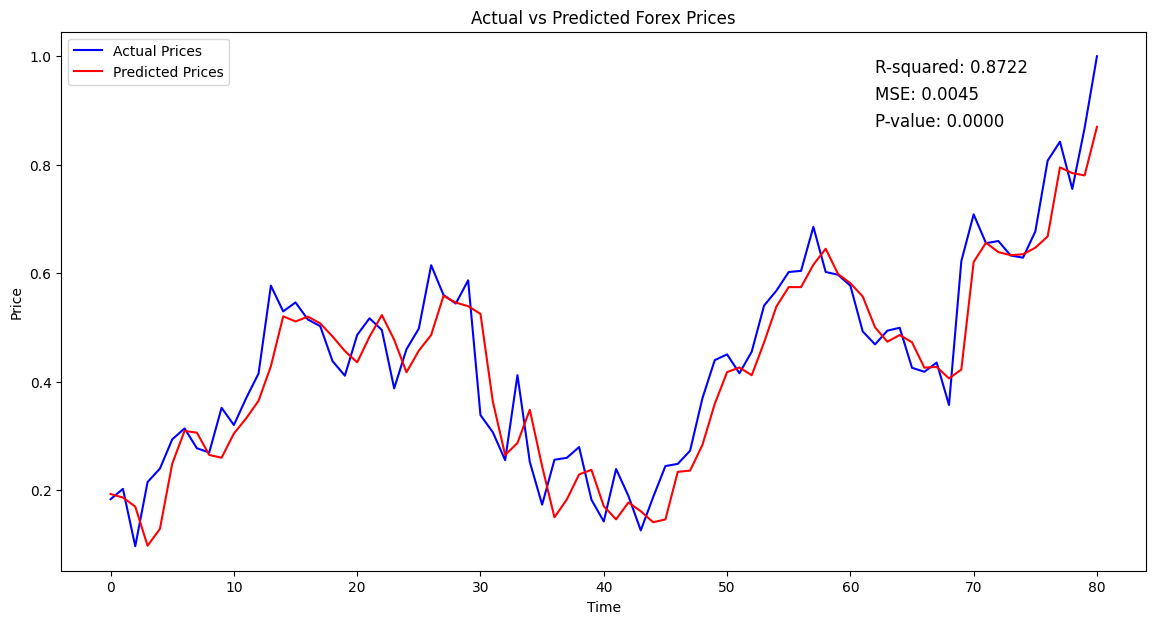

In [9]:
# Plot the actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(actual_prices, color='blue', label='Actual Prices')
plt.plot(predicted_prices, color='red', label='Predicted Prices')
plt.title('Actual vs Predicted Forex Prices')
plt.xlabel('Time')
plt.ylabel('Price')

# Display the metrics on the right top of the plot
plt.text(0.75, 0.95, f'R-squared: {r_squared:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.75, 0.90, f'MSE: {mse:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.75, 0.85, f'P-value: {p_values[1]:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.legend()
plt.show()